In [6]:
# load in csv file
import csv
import numpy as np
import wave
import struct

x_trainAFile = [] # wave filename 
y_trainA = [] # label 

x_trainBFile = [] # wave filename 
y_trainB = [] # label 

# ignores all entries that are less than 2 seconds
def moreNsecs(file, N):
    f = wave.open(file)
    frames = f.readframes(-1)
    samples = struct.unpack('h'*f.getnframes(), frames)
    framerate = f.getframerate()
    t = [float(i)/framerate for i in range(len(samples))]
    if t[-1] > 2:
        return True
    else:
        return False

# ignores all entries without a label
with open('set_a.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if not row[2]=='' and not row[2]=='label': 
            if moreNsecs(row[1],2):
                x_trainAFile.append(row[1])
                y_trainA.append(row[2])
print(len(x_trainAFile))

with open('set_b.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if not row[2]=='' and not row[2]=='label': #and 'noisy' not in row[1]:
            fname = 'set_b/' + row[1][16:]
            new_fname = ''
            count = 0
            for c in fname:
                new_fname += c
                if c == '_' and 'noisy' not in row[1]:
                    if count == 1:
                       new_fname += '_' 
                    count += 1
            if moreNsecs(new_fname,2):
                x_trainBFile.append(new_fname)
                y_trainB.append(row[2])
print(len(x_trainBFile))

120
407


In [44]:
from pylab import *

def get_signal(file):
    f = wave.open(file)
    frames = f.readframes(-1)
    samples = struct.unpack('h'*f.getnframes(), frames)
    return samples

In [45]:
# dataset A, import sound files
x_trainA_raw = [] # features
for i in range(len(x_trainAFile)):
    x_trainA_raw.append(np.array(get_signal(x_trainAFile[i])))
x_trainA_raw = np.array(x_trainA_raw)
print(x_trainA_raw.shape)

# dataset B, import sound files
x_trainB_raw = [] # features
for i in range(len(x_trainBFile)):
    x_trainB_raw.append(np.array(get_signal(x_trainBFile[i])))
x_trainB_raw = np.array(x_trainB_raw)
print(x_trainB_raw.shape)

(120,)
(264,)


In [46]:
# using wavelet decomposition
import pywt
import seaborn
from statsmodels.robust import mad

In [5]:
# TO-DO: play around with these variables
'''def waveletSmooth( x, wavelet="gaus", level=1, title=None ):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    #plot( x, color="b", alpha=0.5 )
    #plot( y, color="b" )
    #show()
    return y'''

In [35]:
'''x_trainA = []
for samples in x_trainA_raw:
    x_smoothed = waveletSmooth(samples, level=4)
    x_trainA.append(x_smoothed)
    #plot(samples,'r')
    #plot(x_smoothed,'b')
    #show()
x_trainA = np.array(x_trainA)
print(x_trainA.shape)

x_trainB = []
for samples in x_trainB_raw:
    x_smoothed = waveletSmooth(samples, level=4)
    x_trainB.append(x_smoothed)
    #plot(samples,'r')
    #plot(x_smoothed,'b')
    #show()
x_trainB = np.array(x_trainB)
print(x_trainB.shape)'''

(120,)
(264,)


In [47]:
# downsample by a factor of 10
def down_sample(x, factor=10):
    r = range(len(x))
    down_array = []
    for i in r[0::factor]:
        down_array.append(x[i])
    return down_array

In [48]:
print(len(x_trainA_raw[0]))
x_trainA = []
x_trainA = np.array([down_sample(sample) for sample in x_trainA_raw])
print(len(x_trainA[0]))
print(x_trainA.shape)

396900
39690
(120,)


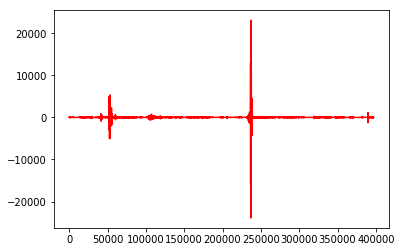

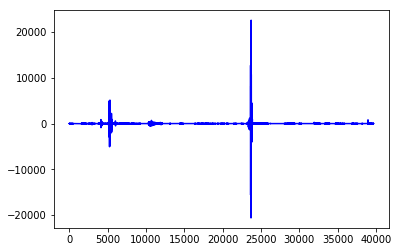

In [49]:
figure()
plot(x_trainA_raw[0],'r')
figure()
plot(x_trainA[0],'b')
show()

In [50]:
# 4th-level Order Six Daubechies filter
x_trainA = np.array([pywt.dwt(x,'db4')[0] for x in x_trainA])
print(len(x_trainA[0]))
print(x_trainA.shape)

19848
(120,)


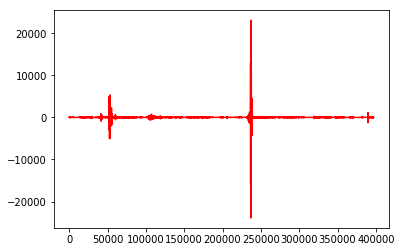

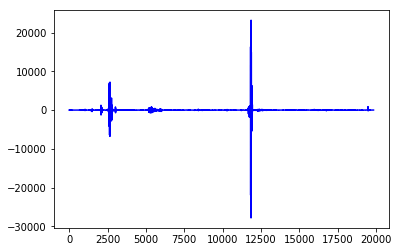

In [51]:
figure()
plot(x_trainA_raw[0],'r')
figure()
plot(x_trainA[0],'b')
show()

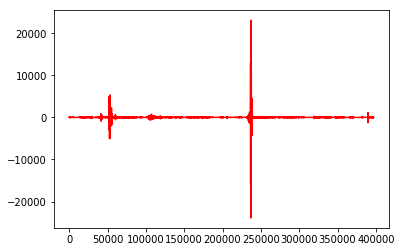

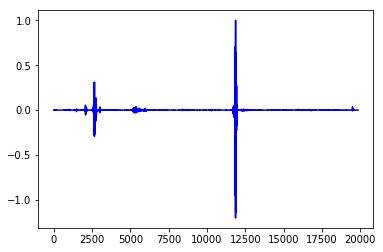

(120, 7138)


In [76]:
# normalize 
x_trainA = np.array([x/max(x) for x in x_trainA])
figure()
plot(x_trainA_raw[0],'r')
figure()
plot(x_trainA[0],'b')
show()

min_length = min(map(len, x_trainA))
x_trainA = np.array([x[:min_length] for x in x_trainA])
print(x_trainA.shape)

In [72]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_trainA = le.fit_transform(y_trainA) # 0 - artifact, 1 - extrahls, 2 - murmur, 3 - normal

In [78]:
from sklearn import svm
from sklearn.model_selection import KFold

# split into train/test
kf = KFold(n_splits=2)
results = []
for tr, ts in kf.split(x_trainA):
    print("Performing training on fold...")
    clf = svm.SVC(probability=True, kernel='rbf')
    #clf.fit(x_trainA[tr], y_trainA[tr])
    results.append(clf.fit(x_trainA[tr], y_trainA[tr]).score(x_trainA[ts],y_trainA[ts]))
print(np.average(results))

Performing training on fold...
Performing training on fold...
0.0


In [62]:
print(x_trainA[0])
print(y_trainB[0])

[ -1.02459512e-04  -3.08868117e-04   1.40288805e-04 ...,  -4.71412099e-05
  -3.78229412e-04   4.15478353e-04]
extrastole
